Code from the MXNet ["Handwritten Digit Recognition"][0] Tutorial.

  [0]: https://mxnet.incubator.apache.org/tutorials/python/mnist.html

__Building the Network__

In [1]:
import mxnet as mx
mnist = mx.test_utils.get_mnist()
batch_size = 100
train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

data = mx.sym.var('data')
data = mx.sym.flatten(data=data)

fc1 = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type='relu')

fc2 = mx.sym.FullyConnected(data=act1, num_hidden=64)
act2 = mx.sym.Activation(data=fc2, act_type='relu')

fc3 = mx.sym.FullyConnected(data=act2, num_hidden=10)
mlp = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

__Training the Network__

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
mlp_model.fit(
  train_iter,
  eval_data=val_iter,
  optimizer='sgd',
  optimizer_params={'learning_rate': 0.1},
  eval_metric='acc',
  batch_end_callback = mx.callback.Speedometer(batch_size, 100),
  num_epoch=10
)

INFO:root:Epoch[0] Batch [100]	Speed: 15370.95 samples/sec	accuracy=0.114059
INFO:root:Epoch[0] Batch [200]	Speed: 22520.64 samples/sec	accuracy=0.110900
INFO:root:Epoch[0] Batch [300]	Speed: 22738.47 samples/sec	accuracy=0.103500
INFO:root:Epoch[0] Batch [400]	Speed: 17926.53 samples/sec	accuracy=0.114300
INFO:root:Epoch[0] Batch [500]	Speed: 27931.34 samples/sec	accuracy=0.116400
INFO:root:Epoch[0] Train-accuracy=0.197576
INFO:root:Epoch[0] Time cost=2.926
INFO:root:Epoch[0] Validation-accuracy=0.248000
INFO:root:Epoch[1] Batch [100]	Speed: 20544.37 samples/sec	accuracy=0.424752
INFO:root:Epoch[1] Batch [200]	Speed: 21262.26 samples/sec	accuracy=0.614500
INFO:root:Epoch[1] Batch [300]	Speed: 22979.77 samples/sec	accuracy=0.755100
INFO:root:Epoch[1] Batch [400]	Speed: 21877.64 samples/sec	accuracy=0.803900
INFO:root:Epoch[1] Batch [500]	Speed: 25920.27 samples/sec	accuracy=0.825200
INFO:root:Epoch[1] Train-accuracy=0.857879
INFO:root:Epoch[1] Time cost=2.733
INFO:root:Epoch[1] Validat

__Testing the Network's Accuracy__

In [3]:
test_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)
acc = mx.metric.Accuracy()
mlp_model.score(test_iter, acc)
print(acc)
assert acc.get()[1] > 0.96

EvalMetric: {'accuracy': 0.97050000000000003}


__Plot network weights and biases__

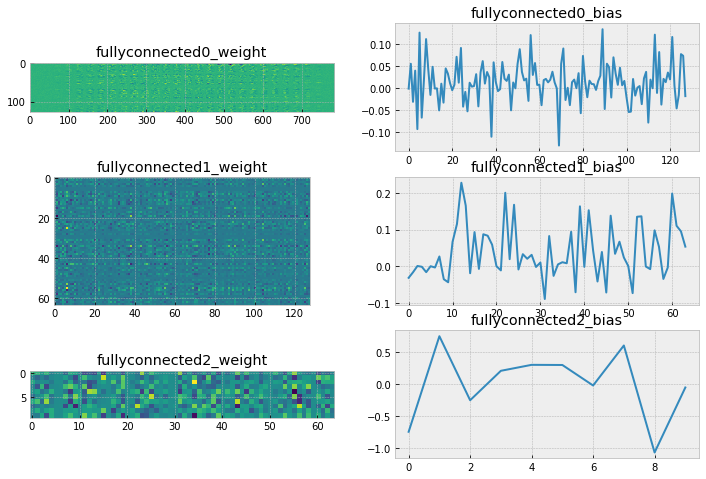

In [4]:
%matplotlib inline
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib import style
style.use('bmh')

# Extract weights and biases.
w1 = mlp_model._arg_params[fc1.name + '_weight'].asnumpy()
w2 = mlp_model._arg_params[fc2.name + '_weight'].asnumpy()
w3 = mlp_model._arg_params[fc3.name + '_weight'].asnumpy()
b1 = mlp_model._arg_params[fc1.name + '_bias'].asnumpy()
b2 = mlp_model._arg_params[fc2.name + '_bias'].asnumpy()
b3 = mlp_model._arg_params[fc3.name + '_bias'].asnumpy()

fig = plt.figure()
fig.set_size_inches(12, 8)
grid_outer = gridspec.GridSpec(1, 2)
grid_left = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid_outer[0])
grid_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid_outer[1])

for i, (sym, w) in enumerate(zip([fc1, fc2, fc3], [w1, w2, w3])):
  ax = fig.add_subplot(grid_left[i])
  ax.set_title(sym.name + '_weight')
  ax.imshow(w)
  
for i, (sym, b) in enumerate(zip([fc1, fc2, fc3], [b1, b2, b3])):
  ax = fig.add_subplot(grid_right[i])
  ax.set_title(sym.name + '_bias')
  ax.plot(b)

plt.show()

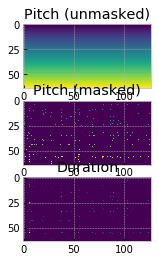

/home/niklas/.local/lib/python3.6/site-packages/midiutil/MidiFile.py:899: FutureWarning: Please explicitly set adjust_origin. Default behaviour will change in a future version.
  FutureWarning)


/home/niklas/nextcloud/data/niklas/files/jupyter/notebooks/Sonification/Neural Net MNIST/fc2w.mid

/home/niklas/nextcloud/data/niklas/files/jupyter/notebooks/Sonification/Neural Net MNIST/fc2b.mid

In [22]:
import numpy as np


def convert_weights_to_midi(fname, w, bpm, volume, speed, note_min, note_max, threshold, plot=False):
  # Normalize the weight rangw, e to 0-1.
  w = (w - np.min(w)) / (np.max(w) - np.min(w))

  # The pitches are distributed evenly (like a gradient from note_min to note_max).
  # They are only activate when the respective wheight is above the threshold.
  p_single = np.linspace(note_min, note_max, w.shape[0])
  p = np.tile([p_single], (w.shape[1], 1))
  p = p.astype(np.int8)

  # The note duration
  d = (w.T - threshold) / (1.0 - threshold)
  d[d < 0.0] = 0.0

  if plot:
    pm = p.copy()
    pm[w.T < threshold] = -1

    axs = plt.subplots(3, 1)[1]
    axs[0].imshow(p.T); axs[0].set_title('Pitch (unmasked)')
    axs[1].imshow(pm.T); axs[1].set_title('Pitch (masked)')
    axs[2].imshow(d.T); axs[2].set_title('Duration')
    plt.show()

  # Write the MIDI file.
  from midiutil.MidiFile import MIDIFile
  midi = MIDIFile(1, adjust_origin=True)  # 1 track
  midi.addTempo(0, 0, bpm)
  for i in range(p.shape[0]):
    t = i / speed
    for j in range(p.shape[1]):
      if w.T[i][j] >= threshold:
        midi.addNote(0, 0, p[i][j], t, d[i][j] * 4, volume)
  with open(fname, 'wb') as fp:
    midi.writeFile(fp)

def convert_bias_to_midi(fname, b, bpm, volume, speed, note_min, note_max):
  notes = (b - np.min(b)) / (np.max(b) - np.min(b)) * (note_max - note_min) + note_min
  midi = MIDIFile(1)
  midi.addTempo(0, 0, bpm)
  for i, p in enumerate(notes):
    t = i / speed
    d = 1 / speed
    midi.addNote(0, 0, int(p), t, d, volume)
  with open(fname, 'wb') as fp:
    midi.writeFile(fp)
    
convert_weights_to_midi('fc2w.mid', w2, bpm=120, volume=100, speed=10, note_min=36, note_max=95, threshold=0.6, plot=True)
convert_bias_to_midi('fc2b.mid', b2, bpm=120, volume=100, speed=10, note_min=36, note_max=95)

from IPython.display import display, FileLink
display(FileLink('fc2w.mid'))
display(FileLink('fc2b.mid'))